<a href="https://colab.research.google.com/github/Sts87/FlightOnTime/blob/feature%2Fmodel-training/FlightOnTime_Modelado%202.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### CARGA DE DATOS

In [144]:
# DATASET
# Airline:  aerolínea
# Flight:   tipo de aeronave
# Time:     hora de salida en minutos (desde medianoche)
# Length:   tiempo de vuelo en minutos
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/main/data/Airlines.csv'
df = pd.read_csv(url)

### INSPECCIÓN INICIAL

In [145]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [146]:
df.shape

(539383, 9)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


### LIMPIEZA DE DATOS

In [148]:
# ELIMINAR COLUMNA CODIGO
df.drop('id', axis=1, inplace=True)

In [149]:
(df == '').sum()

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


In [150]:
#Esta línea tiene una advertencia por no haber valores nulos
#Esto no debiera afectar al dataset ni el analisis ni el machinelearning

df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df.replace('', np.nan, inplace=True)
df.isnull().sum()

#Alternativa para evitar adventerncia
#df.replace('', np.nan, inplace=True)

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


### ANÁLISIS ESTADÍSTICO

In [151]:
# VARIABLES NÚMERICAS
# RMC: Tomar en cuenta solo 'Time', 'Length'
df[['Time', 'Length']].describe().round(1)

,Time,Length
count,539383.0,539383.0
mean,802.7,132.2
std,278.0,70.1
min,10.0,0.0
25%,565.0,81.0
50%,795.0,115.0
75%,1035.0,162.0
max,1439.0,655.0


In [152]:
# VARIABLES CATEGÓRICAS
df.describe(include='object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


### PROPORCIÓN DE CLASES DE LA VARIABLE OBJETIVO

In [153]:
# IDENTIFICAR SI HAY DESBALANCEO
# No hay desbalanceo: proporcion 55-45%
df_cnt = df['Delay'].value_counts()
df_pct = df['Delay'].value_counts(normalize=True).round(2) * 100

df_delay = pd.concat([df_cnt, df_pct], axis=1)
df_delay

,count,proportion
Delay,,
0,299119,55.0
1,240264,45.0


### NUEVAS VARIABLES

In [154]:
# Nuevas variables candidatas:
# Hour (hh:mm)
df['Hour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['Hour'] = pd.to_datetime(df['Hour'], format="%H:%M")

# Time of day: Momento del dia de la salida del vuelo
clases = [0, 360, 720, 1080, 1440]
labels = ['Early morning', 'Morning', 'Afternoon', 'Night']
df['TimeDay'] = pd.cut(x=df['Time'], bins=clases, labels=labels, include_lowest=True)

# Duration
clases = [0, 90, 180, 960]
labels = ['Short', 'Medium', 'Long']
df['Duration'] = pd.cut(x=df['Length'], bins=clases, labels=labels, include_lowest=True)

### ANALISIS DESCRIPTIVO

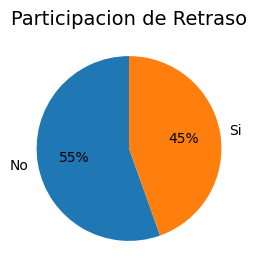

In [155]:
# Retraso: 55% a tiempo, 45% retraso
plt.figure(figsize=(4, 3))
plt.pie(df['Delay'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Retraso', fontsize=14)

plt.show()
# plt.savefig("participacion_target.png", bbox_inches='tight', dpi=300)
# plt.close()

In [156]:
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())
df2

,DayOfWeek,Delay,NumFlights,PctFlights
0,1,0,38739,0.532356
1,1,1,34030,0.467644
2,2,0,39427,0.552663
3,2,1,31913,0.447337
4,3,0,47492,0.529182
5,3,1,42254,0.470818
6,4,0,50201,0.548975
7,4,1,41244,0.451025
8,5,0,49733,0.583392
9,5,1,35515,0.416608


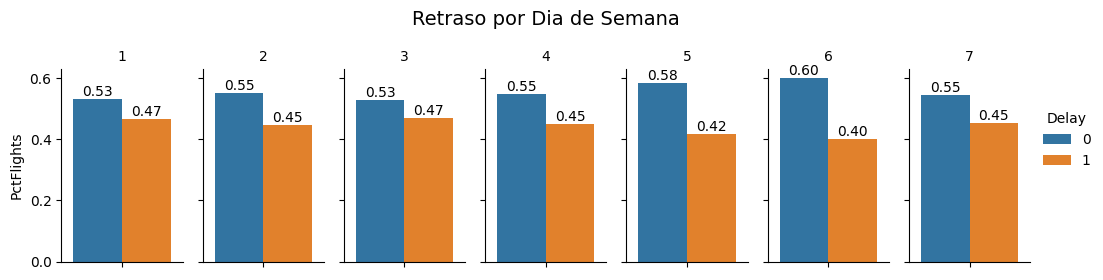

In [157]:
# Retraso por Dia de semana:
# -Dias 5 y 6 tienen menores retrasos
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="DayOfWeek",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Dia de Semana", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_dia_semana.png", bbox_inches='tight', dpi=300)
# plt.close()

## Modelado

In [158]:
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/feature/model-training/Airlines_processed.csv'
data = pd.read_csv(url)

In [159]:
data.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Hour,TimeDay,Duration
0,CO,269,SFO,IAH,3,15,205,1,0.250000,Early morning,Long
1,US,1558,PHX,CLT,3,15,222,1,0.250000,Early morning,Long
2,AA,2400,LAX,DFW,3,20,165,1,0.333333,Early morning,Medium
3,AA,2466,SFO,DFW,3,20,195,1,0.333333,Early morning,Long
4,AS,108,ANC,SEA,3,30,202,0,0.500000,Early morning,Long


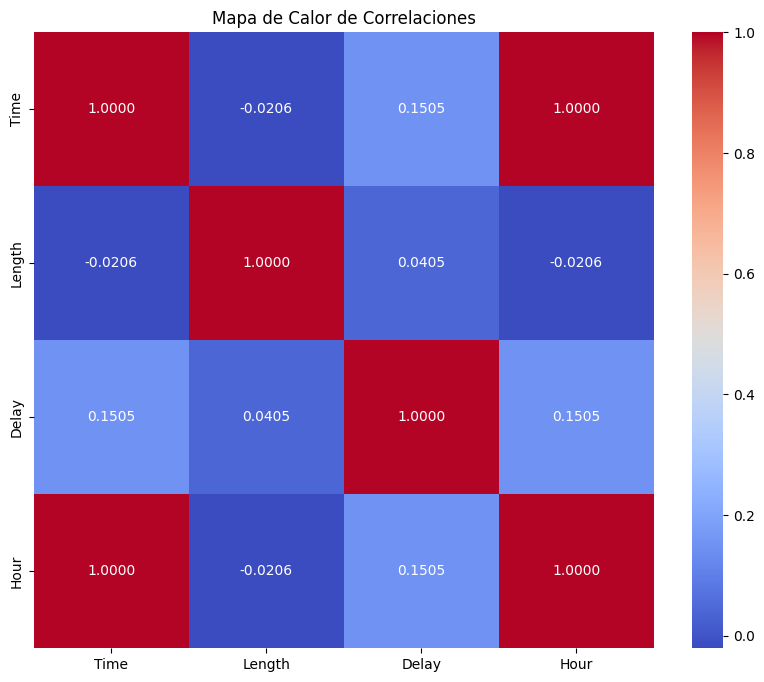

In [160]:
numerico = ['Time', 'Length', 'Delay', 'Hour']
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerico].corr(), annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Mapa de Calor de Correlaciones')
plt.savefig('correlation_heatmap.png')

## Preparación del DataFrame

In [161]:
eliminar = ['Flight','AirportFrom', 'AirportTo','Time', 'TimeDay', 'Duration']
data.drop(columns=eliminar, inplace=True)
data.head()

,Airline,DayOfWeek,Length,Delay,Hour
0,CO,3,205,1,0.250000
1,US,3,222,1,0.250000
2,AA,3,165,1,0.333333
3,AA,3,195,1,0.333333
4,AS,3,202,0,0.500000


In [162]:
# Se selecciona los valores mayores que 0
data = data[data['Length']>0]

## Preprocesamiento

In [167]:
# Configuración
RANDOM_STATE = 42

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

X = data.drop(columns='Delay')
y = data['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True , stratify=y)

cat_cols = ['Airline', 'DayOfWeek']
num_cols = ['Length', 'Hour']

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=True
        ), cat_cols),
        ("num", RobustScaler(), num_cols),
    ],
    remainder="drop"
)

pipeline_lr = Pipeline([
    ('pre', preprocess),
    ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

pipeline_rf = Pipeline([
    ('pre', preprocess),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

## Entrenamiento de modelos

In [ ]:
# Logistic Regression y Random Forest

pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

In [ ]:
print("--- LOGÍSTICA ---")
print(classification_report(y_test, y_pred_lr))
print("\n--- RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(y_test, y_pred_lr)
ax[0].set_title("Matriz Logística")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
ax[1].set_title("Matriz Random Forest")

plt.show()

In [ ]:
# ==========================
# MODELADO + COMPARACIÓN (LR vs RF) + THRESHOLD OPTIMIZADO + EXPORT
# ==========================

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# --------------------------
# 0) Config (ajustable)
# --------------------------
RANDOM_STATE = 42

# Para que corra rápido en notebook
N_SAMPLE_LR = 200000   # LR puede con más datos
N_SAMPLE_RF = 120000   # RF en muestra (evita que se quede colgado)

# Control de OneHot (evita explosión de columnas)
MIN_FREQ = 100
MAX_CATEGORIES = 200

# Threshold base (MVP)
BASE_THRESHOLD = 0.5

# --------------------------
# 1) Preparación del dataframe
# --------------------------
df_model = df.copy()

# Asegurar drop de id si existe (en tu notebook ya lo hacen, pero acá queda robusto)
if "id" in df_model.columns:
    df_model.drop(columns=["id"], inplace=True)

# Quitar anomalías (en este dataset existen Length=0)
df_model = df_model[df_model["Length"] > 0].copy()

# Para MVP: Flight suele ser alta cardinalidad y puede ralentizar / sobreajustar
if "Flight" in df_model.columns:
    df_model.drop(columns=["Flight"], inplace=True)

# Asegurar target y features
if "Delay" not in df_model.columns:
    raise ValueError("No se encuentra la columna target 'Delay' en df_model.")

y_full = df_model["Delay"].astype(int)
X_full = df_model.drop(columns=["Delay"])

# Columnas categóricas y numéricas (incluye TimeDay/Duration si existen en tu notebook)
cat_cols = [c for c in ["Airline", "AirportFrom", "AirportTo", "TimeDay", "Duration"] if c in X_full.columns]
num_cols = [c for c in ["Time", "Length"] if c in X_full.columns]

print("Columnas categóricas:", cat_cols)
print("Columnas numéricas:", num_cols)
print("Filas totales para modelado:", len(df_model))

# --------------------------
# 2) Muestreo (para velocidad)
# --------------------------
if len(df_model) > N_SAMPLE_LR:
    df_lr = df_model.sample(n=N_SAMPLE_LR, random_state=RANDOM_STATE)
else:
    df_lr = df_model.copy()

if len(df_model) > N_SAMPLE_RF:
    df_rf = df_model.sample(n=N_SAMPLE_RF, random_state=RANDOM_STATE)
else:
    df_rf = df_model.copy()

# --------------------------
# 3) Preprocesamiento
# --------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            min_frequency=MIN_FREQ,
            max_categories=MAX_CATEGORIES,
            sparse_output=True
        ), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# --------------------------
# 4) Modelos
# --------------------------
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=400,
        solver="saga",
        n_jobs=-1
    ))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=150,
        max_depth=18,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

# --------------------------
# 5) Helpers de evaluación
# --------------------------
def eval_with_threshold(model, X_train, X_test, y_train, y_test, threshold=0.5):
    """Entrena model, predice y devuelve métricas a threshold dado."""
    model.fit(X_train, y_train)

    if not hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": np.nan,
            "threshold": np.nan
        }

    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, proba),
        "threshold": float(threshold)
    }

def find_best_threshold_for_f1(model, X_train, X_test, y_train, y_test, thresholds=None):
    """Entrena model y busca el threshold que maximiza F1."""
    if thresholds is None:
        thresholds = np.linspace(0.2, 0.8, 25)

    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    best = None
    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_test, pred, zero_division=0)
        p = precision_score(y_test, pred, zero_division=0)
        r = recall_score(y_test, pred, zero_division=0)
        a = accuracy_score(y_test, pred)
        row = {"threshold": float(t), "f1": f1, "precision": p, "recall": r, "accuracy": a}
        if best is None or row["f1"] > best["f1"]:
            best = row

    return best

# --------------------------
# 6) Entrenar + evaluar Logistic Regression (threshold 0.5 + threshold óptimo F1)
# --------------------------
print("\n--- Entrenando Logistic Regression ---")
y_lr = df_lr["Delay"].astype(int)
X_lr = df_lr.drop(columns=["Delay"])

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.2, stratify=y_lr, random_state=RANDOM_STATE
)

lr_base = eval_with_threshold(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, threshold=BASE_THRESHOLD)
best_thr = find_best_threshold_for_f1(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

# Re-evaluar LR con el mejor threshold encontrado
lr_best = eval_with_threshold(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, threshold=best_thr["threshold"])

print("LR listo. Best threshold (por F1):", best_thr["threshold"])

# --------------------------
# 7) Entrenar + evaluar Random Forest (threshold 0.5)
# --------------------------
print("\n--- Entrenando Random Forest ---")
y_rf = df_rf["Delay"].astype(int)
X_rf = df_rf.drop(columns=["Delay"])

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, stratify=y_rf, random_state=RANDOM_STATE
)

rf_base = eval_with_threshold(pipe_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, threshold=BASE_THRESHOLD)
print("RF listo.")

# --------------------------
# 8) Tabla final comparativa
# --------------------------
results = pd.DataFrame([
    {"model": "LogisticRegression (thr=0.5)", **lr_base, "train_rows": len(df_lr)},
    {"model": f"LogisticRegression (thr={lr_best['threshold']:.2f} best F1)", **lr_best, "train_rows": len(df_lr)},
    {"model": "RandomForest (thr=0.5)", **rf_base, "train_rows": len(df_rf)},
]).sort_values("f1", ascending=False)

results

# --------------------------
# 9) Selección del modelo final + export
# --------------------------
# Regla simple: elegir el de mejor F1 en results
best_row = results.iloc[0]
best_model_name = best_row["model"]
print("\nMejor configuración por F1:", best_model_name)

# Si el mejor es LR, dejamos pipe_lr entrenado ya sobre el split de LR y exportamos.
# Si el mejor es RF, exportamos pipe_rf (entrenado en su split).
if "RandomForest" in best_model_name:
    final_model = pipe_rf
    final_threshold = BASE_THRESHOLD
else:
    final_model = pipe_lr
    final_threshold = float(best_row["threshold"]) if not pd.isna(best_row["threshold"]) else BASE_THRESHOLD

joblib.dump({"model": final_model, "threshold": final_threshold}, "flight_delay_bundle.joblib")
print("Exportado: flight_delay_bundle.joblib (incluye modelo + threshold)")

# --------------------------
# 10) Función de inferencia para API (devuelve probabilidad + label)
# --------------------------
def predict_payload(payload_features: dict):
    """
    payload_features debe venir con keys como:
    Airline, AirportFrom, AirportTo, DayOfWeek, Time, Length
    (y TimeDay/Duration si tu modelo las usa y tu API las manda; si no, NO las incluyas).
    """
    bundle = joblib.load("flight_delay_bundle.joblib")
    model = bundle["model"]
    threshold = bundle["threshold"]

    X_one = pd.DataFrame([payload_features])
    prob = float(model.predict_proba(X_one)[0, 1])
    pred = int(prob >= threshold)
    return {"prevision": "Retrasado" if pred == 1 else "Puntual", "probabilidad": prob, "threshold": float(threshold)}

# Ejemplo rápido (ajusta valores)
# sample = {"Airline":"AA","AirportFrom":"SFO","AirportTo":"DFW","DayOfWeek":3,"Time":900,"Length":180}
# predict_payload(sample)


Columnas categóricas: ['Airline', 'AirportFrom', 'AirportTo', 'TimeDay', 'Duration']
Columnas numéricas: ['DayOfWeek', 'Time', 'Length']
Filas totales para modelado: 539379

--- Entrenando Logistic Regression ---
LR listo. Best threshold (por F1): 0.30000000000000004

--- Entrenando Random Forest ---
RF listo.

Mejor configuración por F1: LogisticRegression (thr=0.30 best F1)
Exportado: flight_delay_bundle.joblib (incluye modelo + threshold)


In [ ]:
from IPython.display import display
display(results)


,model,accuracy,precision,recall,f1,roc_auc,threshold,train_rows
1,LogisticRegression (thr=0.30 best F1),0.560350,0.504291,0.885242,0.642546,0.689627,0.3,200000
0,LogisticRegression (thr=0.5),0.644050,0.631384,0.486754,0.549715,0.689627,0.5,200000
2,RandomForest (thr=0.5),0.647833,0.697683,0.373473,0.486513,0.696094,0.5,120000


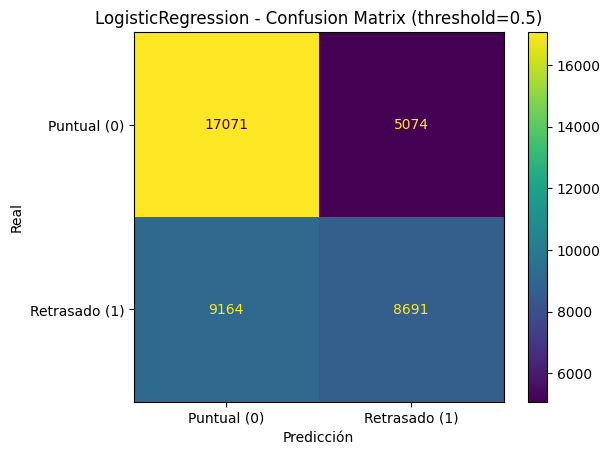

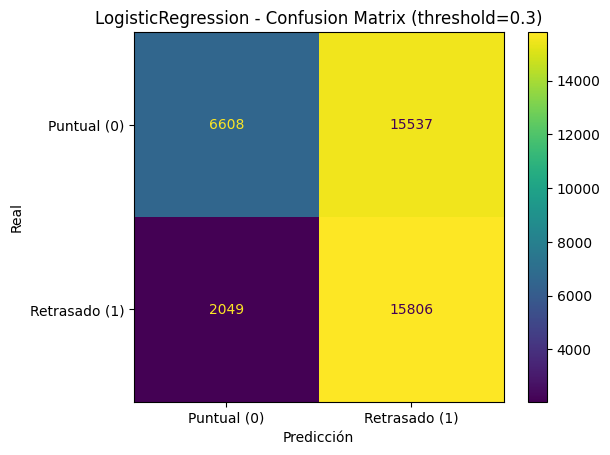

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Asegúrate de que existen (del bloque de LR):
# pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr

# 1) Entrenar y obtener probas
pipe_lr.fit(X_train_lr, y_train_lr)
proba = pipe_lr.predict_proba(X_test_lr)[:, 1]

# 2) Función para graficar la matriz de confusión según threshold (sin figura extra)
def plot_confusion_for_threshold(y_true, proba, threshold, title_prefix="LogisticRegression"):
    y_pred = (proba >= threshold).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Puntual (0)", "Retrasado (1)"],
        values_format="d"
    )
    disp.ax_.set_title(f"{title_prefix} - Confusion Matrix (threshold={threshold})")
    disp.ax_.set_xlabel("Predicción")
    disp.ax_.set_ylabel("Real")
    plt.show()

# 3) Graficar para thresholds 0.5 y 0.3
plot_confusion_for_threshold(y_test_lr, proba, 0.5)
plot_confusion_for_threshold(y_test_lr, proba, 0.3)
